In [3]:
# importing libraries and functions
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
# Processing manoeuvre and orbital data 

In [5]:
# Helper function for Date conversion
def doy_to_datetime(year: int, doy: int, hour: int, minute: int, second: float=0.0):
    return datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)

In [6]:
# Processing manoeuvre file 'cs2man.txt'
def parse_non_fengyun_line(line):
    parts = line.split()
    if len(parts) < 9:
        return None
    try:
        return {
            'satellite': parts[0],
            'start_time': doy_to_datetime(int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4])),
            'end_time': doy_to_datetime(int(parts[5]), int(parts[6]), int(parts[7]), int(parts[8]))
        }
    except Exception as e:
        print(f"Skipping line due to error: {e}")
        return None

def process_manoeuvre_file(path):
    with open(path) as f:
        data = [parse_non_fengyun_line(line.strip()) for line in f if line.strip()]
    return pd.DataFrame([d for d in data if d])


In [7]:
# Processing orbital elements from CryoSat-2.csv file

def load_orbital_elements(filepath: str):
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        df.sort_index(inplace=True)
        df.index.name = 'timestamp' # naming the unnamed column as 'timestamp'
        return df
    except Exception as e:
        print(f"Error loading orbital elements file: {filepath}\n{e}")
        return pd.DataFrame()   


In [12]:
# Loading both files
def main():
    base_dir = '../satellite_data'
    manoeuvre_file = os.path.join(base_dir, 'manoeuvres', 'cs2man.txt')
    orbital_file = os.path.join(base_dir, 'orbital_elements', 'CryoSat-2.csv')

    print(f"\nProcessing manoeuvre file: {manoeuvre_file}")
    man_df = process_manoeuvre_file(manoeuvre_file)
    print(man_df.head())

    print(f"\nProcessing orbital elements file: {orbital_file}")
    orb_df = load_orbital_elements(orbital_file)
    print(orb_df.head())

    return man_df, orb_df

In [13]:
man_df, orb_df = main()


Processing manoeuvre file: ../satellite_data/manoeuvres/cs2man.txt
  satellite          start_time            end_time
0     CRYO2 2010-04-15 17:47:00 2010-04-15 17:48:00
1     CRYO2 2010-05-03 17:55:00 2010-05-04 00:35:00
2     CRYO2 2010-05-04 18:38:00 2010-05-04 18:48:00
3     CRYO2 2010-05-05 17:44:00 2010-05-05 17:59:00
4     CRYO2 2010-05-06 18:26:00 2010-05-06 18:51:00

Processing orbital elements file: ../satellite_data/orbital_elements/CryoSat-2.csv
                            eccentricity  argument of perigee  inclination  \
timestamp                                                                    
2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
2010-04-29 00:34:12.213407      0.001252             3.529150     1.

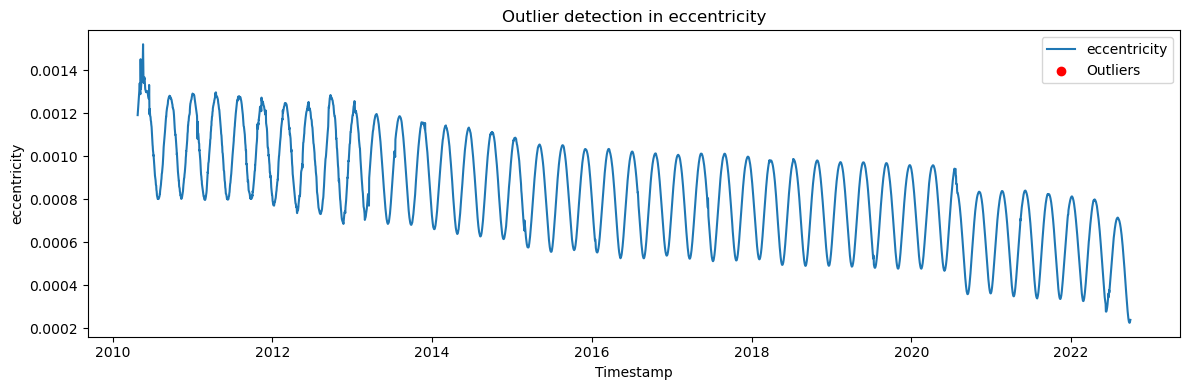

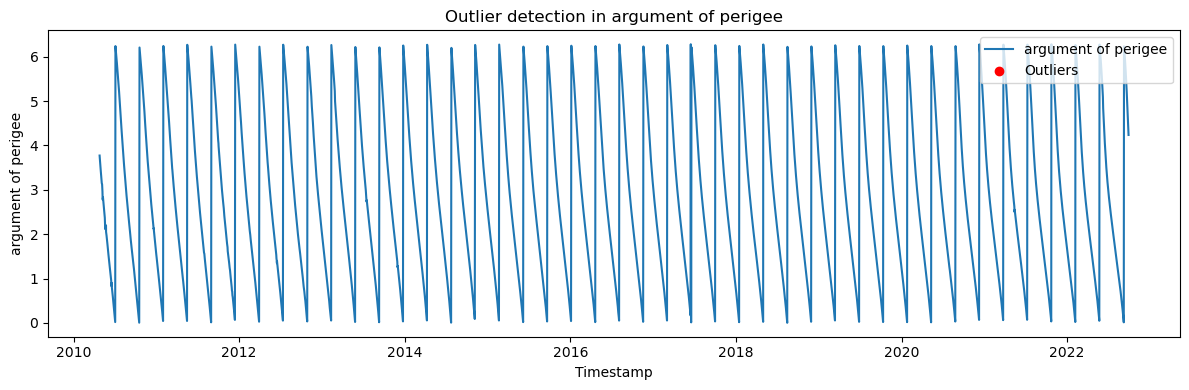

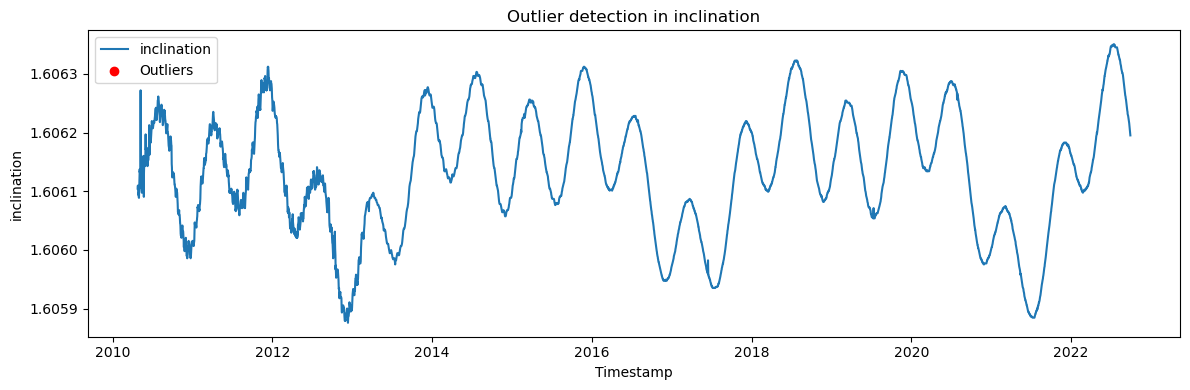

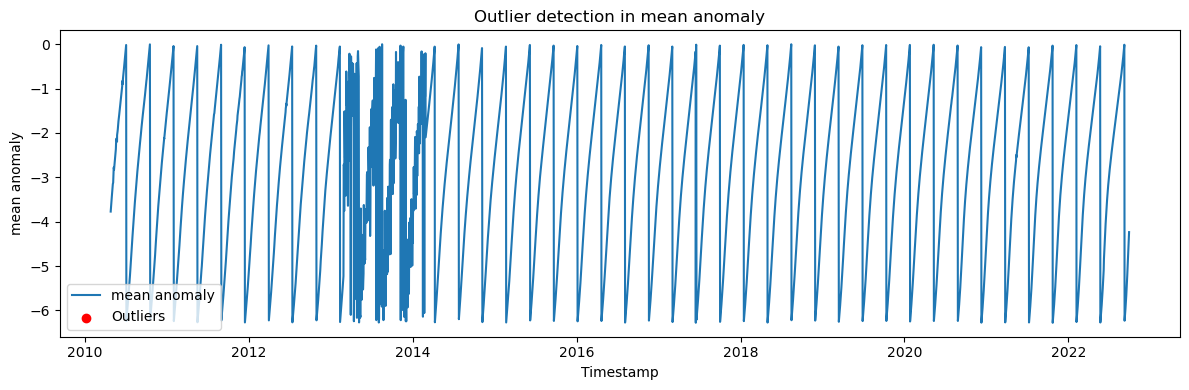

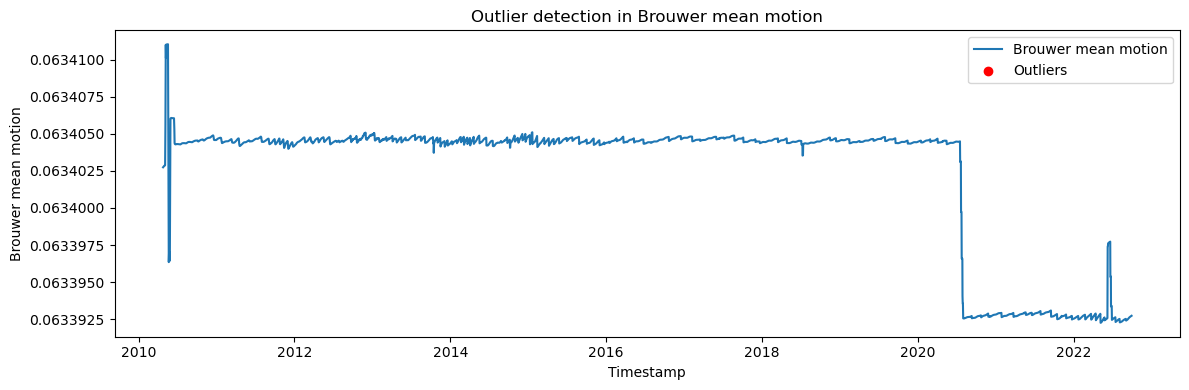

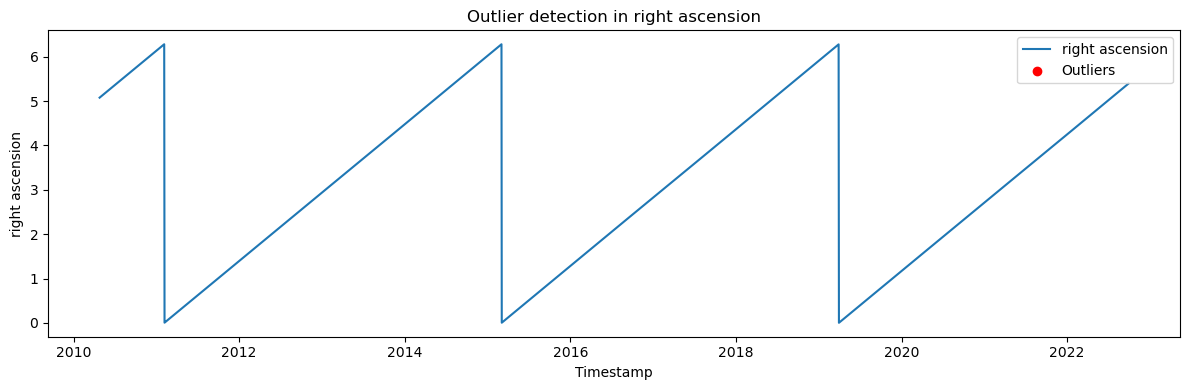

In [14]:
# Detecting outliers using z_scores   

def outlier_detection(df, threshold=3):  # applying standard threshold 3
    z_scores = df.apply(zscore) 
    outliers = (z_scores.abs() > threshold)
    return outliers

def plot_outliers(df, outliers):
    for col in df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df[col], label=col)
        plt.scatter(df.index[outliers[col]], df[col][outliers[col]], color='red', label='Outliers')
        plt.title(f"Outlier detection in {col}")
        plt.legend()
        plt.xlabel("Timestamp")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
outliers = outlier_detection(orb_df)
plot_outliers(orb_df, outliers)

Haven't detected any outlier.  

Mean anomaly has a clear trend with high variance over time which is suitable for ARIMA modelling.
There is no missing values which is evident from the Null Values. hence ARIMA can be applied without any imputation.
Mean Anomaly also has strong negative correlation with other elements. So I'll be only using single orbital element  mean anomaly to create the model.

<Figure size 1000x400 with 0 Axes>

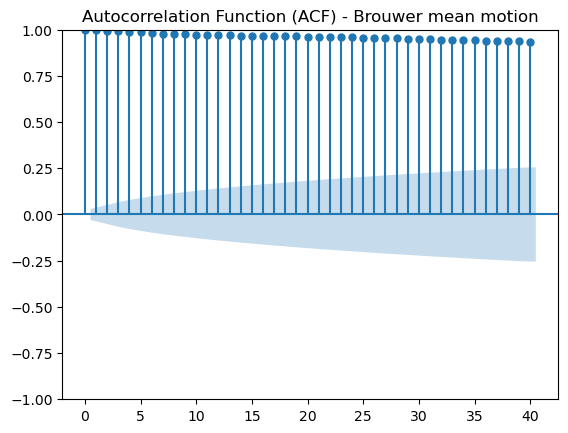

<Figure size 1000x400 with 0 Axes>

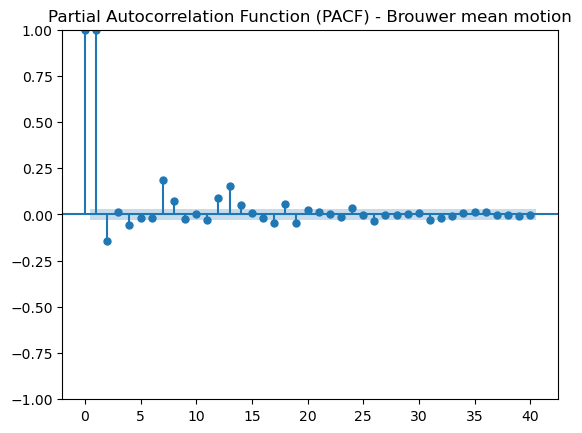

Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).
Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).


 ADF Test
ADF Statistic     : -0.552207
p-value           : 0.881420
Critical Values   :
   1%: -3.4319
   5%: -2.8622
   10%: -2.5671

 The series is NOT stationary.

Conclusion: Fail to reject the null hypothesis (H₀). The series is non-stationary at the 5% significance level.


In [15]:
# Checking stationarity of 'Brouwer mean motion' using ACF and PACF plots

series = orb_df['Brouwer mean motion'].dropna()

# ACF plot
plt.figure(figsize=(10, 4))
plot_acf(series, lags=40)
plt.title('Autocorrelation Function (ACF) - Brouwer mean motion')
plt.show()

# PACF plot
plt.figure(figsize=(10, 4))
plot_pacf(series, lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) - Brouwer mean motion')
plt.show()

# ADF Test

# Print hypotheses
print("Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).")
print("Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).\n")

result = adfuller(series)
print('\n ADF Test')
print(f"ADF Statistic     : {result[0]:.6f}")
print(f"p-value           : {result[1]:.6f}")
print(f"Critical Values   :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")
if result[1] < 0.05:
    print("\n The series is stationary.")
else:
    print("\n The series is NOT stationary.")
    
# Conclusion
if result[1] <= 0.05:
    print("\nConclusion: Reject the null hypothesis (H₀). The series is stationary at the 5% significance level.")
else:
    print("\nConclusion: Fail to reject the null hypothesis (H₀). The series is non-stationary at the 5% significance level.")



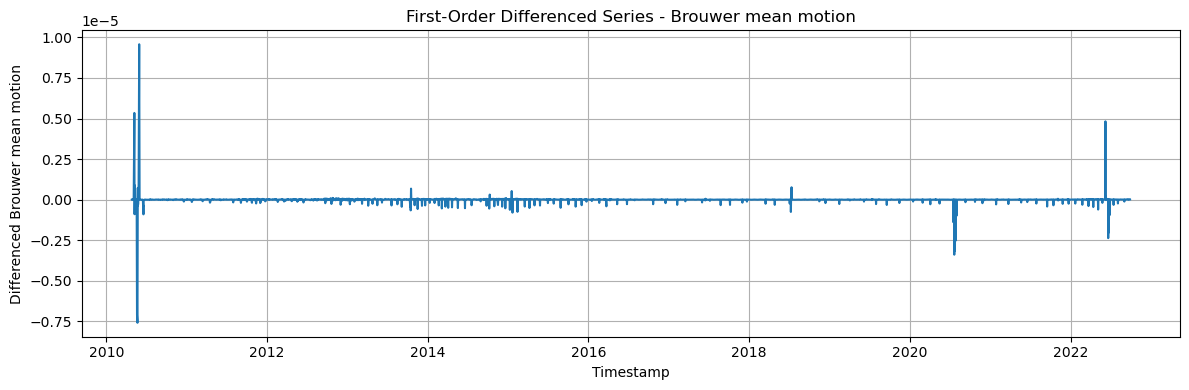


 ADF Test After Differencing
ADF Statistic     : -22.080490
p-value           : 0.000000
Critical Values   :
   1%: -3.4319
   5%: -2.8622
   10%: -2.5671

 The differenced series is stationary.


In [16]:
# First order differencing

# First order differencing
series = orb_df['Brouwer mean motion'].dropna()
diff_series = series.diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 4))
plt.plot(diff_series)
plt.title('First-Order Differenced Series - Brouwer mean motion')
plt.xlabel('Timestamp')
plt.ylabel('Differenced Brouwer mean motion')
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test on differenced series
print('\n ADF Test After Differencing')
result = adfuller(diff_series)
print(f"ADF Statistic     : {result[0]:.6f}")
print(f"p-value           : {result[1]:.6f}")
print(f"Critical Values   :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")
if result[1] < 0.05:
    print("\n The differenced series is stationary.")
else:
    print("\n The differenced series is still not stationary.")


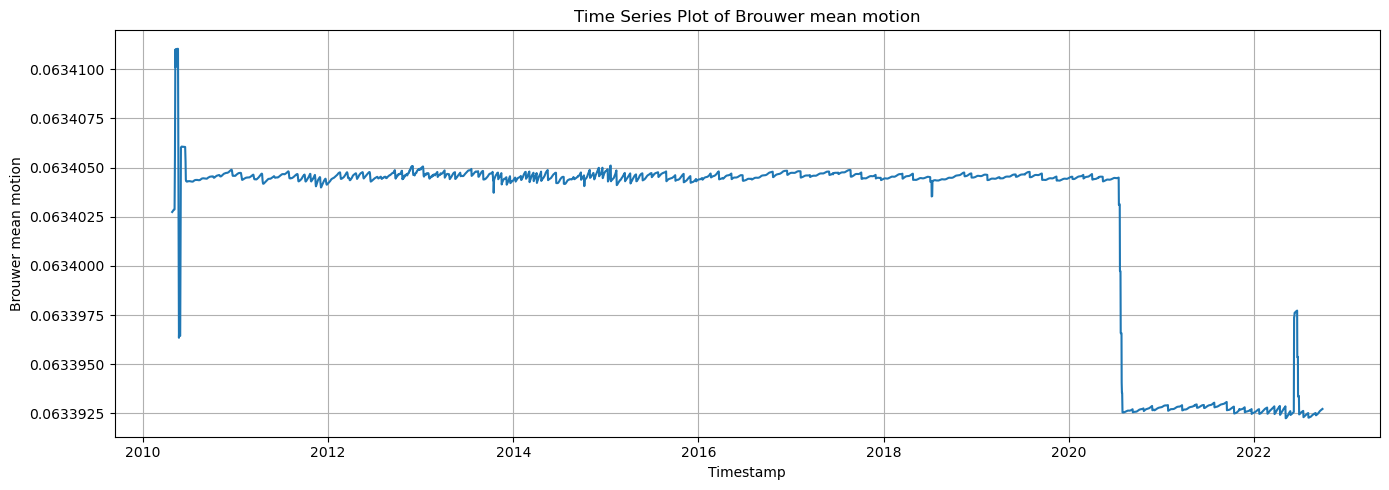

In [17]:
# Plotting the trend only for the selected orbital element mean anomaly.

def plot_trend(df):
    plt.figure(figsize=(14, 5))
    sns.lineplot(x=df.index, y=df['Brouwer mean motion'])
    plt.title("Time Series Plot of Brouwer mean motion")
    plt.xlabel("Timestamp")
    plt.ylabel("Brouwer mean motion")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_trend(orb_df)

In [18]:
# Fill missing values in mean_anomaly
if orb_df['Brouwer mean motion'].isna().sum() > 0:
    orb_df['Brouwer mean motion'] = orb_df['Brouwer mean motion'].ffill()

In [19]:
# Stationarity check

In [20]:
def stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'{title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-stationary"}')
    print("\n")
    return result[1] < 0.05

is_stationary = stationarity(orb_df['Brouwer mean motion'], "Original Brouwer mean motion")

# Resample to daily frequency 
Brouwer_mean_motion_daily = orb_df['Brouwer mean motion'].resample('D').mean().ffill()

# Decompose time series 
from statsmodels.tsa.seasonal import seasonal_decompose

period = 30 
decomposition = seasonal_decompose(Brouwer_mean_motion_daily, model='additive', period=period)

Original Brouwer mean motion
ADF Statistic: -0.5522
p-value: 0.8814
Result: Non-stationary




In [21]:
# Decomposing for Brouwer mean motion

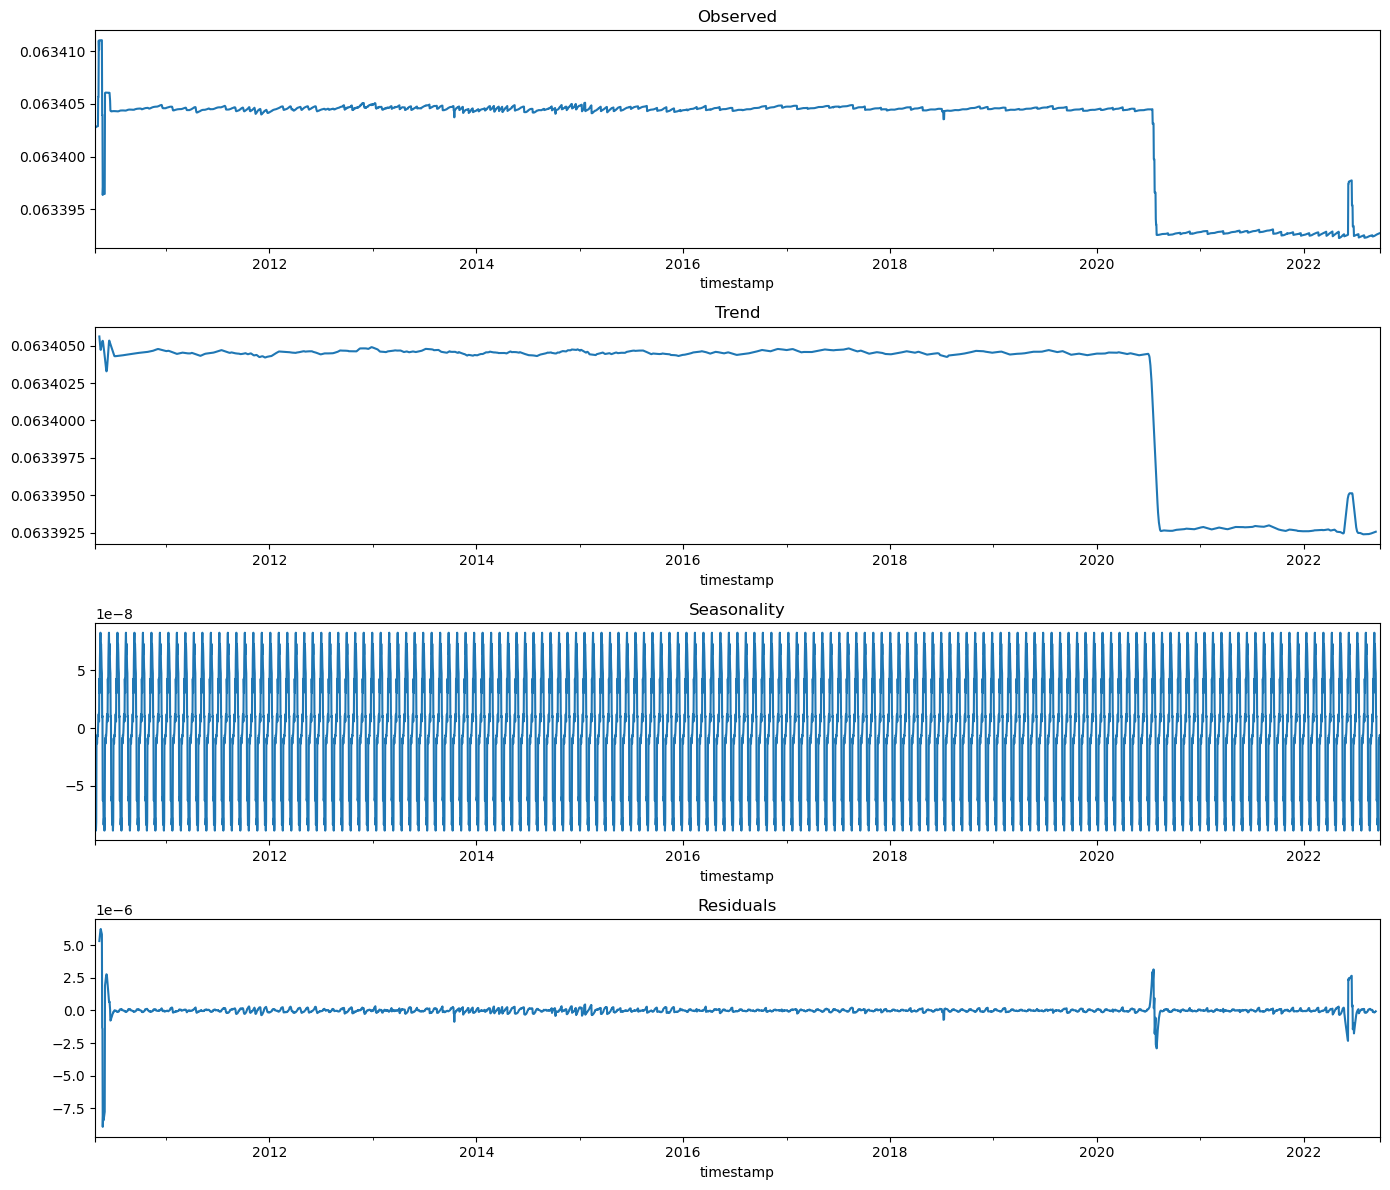

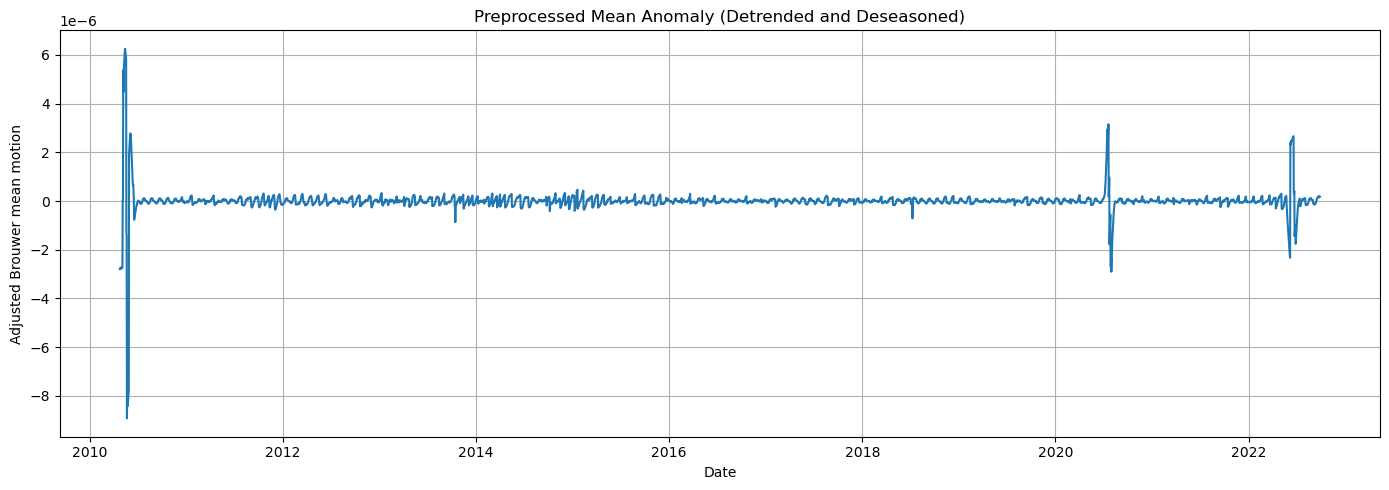

Preprocessed Brouwer mean motion
ADF Statistic: -17.8525
p-value: 0.0000
Result: Stationary




In [23]:
# Plot decomposition 
# Plotting observed, Trend, Seasonality and Residuals
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

# Preprocessing: detrend and deseason
trend = decomposition.trend.ffill().bfill()
seasonal = decomposition.seasonal.ffill().bfill()
detrended_deseasoned = Brouwer_mean_motion_daily - trend - seasonal

# Plotting preprocessed mean anomaly
plt.figure(figsize=(14, 5))
plt.plot(detrended_deseasoned.index, detrended_deseasoned.values)
plt.title("Preprocessed Mean Anomaly (Detrended and Deseasoned)")
plt.xlabel("Date")
plt.ylabel("Adjusted Brouwer mean motion")
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing stationarity of the preprocessed data
is_preprocessed_stationary = stationarity(detrended_deseasoned.dropna(), "Preprocessed Brouwer mean motion")

# Final preprocessed data
preprocessed_data = detrended_deseasoned.dropna()


In [24]:
# Train-test split (80% for training, 20% for testing)

train_size = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:train_size]
test_data = preprocessed_data[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (3632,)
Test data shape: (908,)


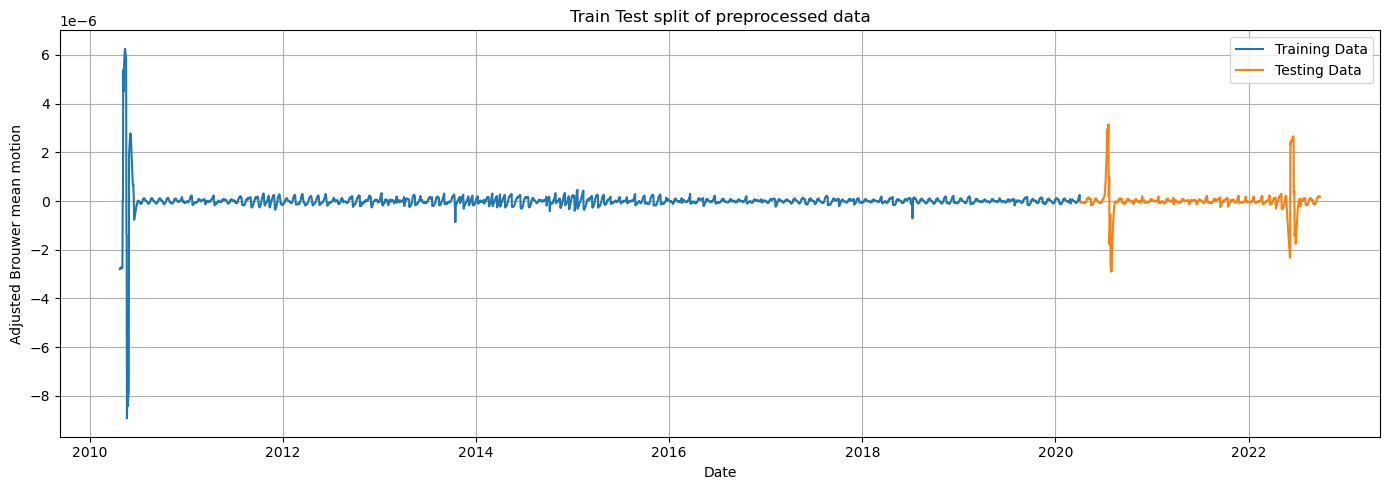

In [25]:
# Plotting the train test split
plt.figure(figsize=(14, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.title("Train Test split of preprocessed data")
plt.xlabel("Date")
plt.ylabel("Adjusted Brouwer mean motion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Grid search

In [27]:
def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_aic = float("inf")
    results = []

    warnings.filterwarnings("ignore") 

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    results.append({
                        'order': (p, d, q),
                        'aic': aic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_cfg = (p, d, q)
                    
                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}")
                except Exception as e:
                    print(f"Error with ARIMA({p},{d},{q}): {str(e)}")
                    continue

    warnings.filterwarnings("default")
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('aic')
        print("\nTop 5 ARIMA Models:")
        print(results_df.head())
    
    print(f"\nBest ARIMA Model: {best_cfg} with AIC: {best_aic:.4f}")
    return best_cfg

# Defining parameter ranges
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_order = grid_search_arima(train_data, p_values, d_values, q_values)


ARIMA(0,0,0) - AIC: -78436.2801
ARIMA(0,0,1) - AIC: -76898.4792
ARIMA(0,0,2) - AIC: -76636.6633
ARIMA(0,0,3) - AIC: -76849.8451
ARIMA(0,1,0) - AIC: -93368.3867
ARIMA(0,1,1) - AIC: -91685.7535
ARIMA(0,1,2) - AIC: -91924.4486
ARIMA(0,1,3) - AIC: -91899.9218
ARIMA(0,2,0) - AIC: -68420.1845
ARIMA(0,2,1) - AIC: inf
ARIMA(0,2,2) - AIC: nan
ARIMA(0,2,3) - AIC: -72722.4493
ARIMA(1,0,0) - AIC: -76925.1108
ARIMA(1,0,1) - AIC: -76901.9251
ARIMA(1,0,2) - AIC: -76878.8144
ARIMA(1,0,3) - AIC: -76855.6279
ARIMA(1,1,0) - AIC: -93365.6061
ARIMA(1,1,1) - AIC: -93339.3122
ARIMA(1,1,2) - AIC: -91395.2019
ARIMA(1,1,3) - AIC: -93134.1278
ARIMA(1,2,0) - AIC: -80711.4701
ARIMA(1,2,1) - AIC: -78185.4380
ARIMA(1,2,2) - AIC: nan
ARIMA(1,2,3) - AIC: -85519.9920
ARIMA(2,0,0) - AIC: -76901.9274
ARIMA(2,0,1) - AIC: -77122.2416
ARIMA(2,0,2) - AIC: -76876.5579
ARIMA(2,0,3) - AIC: -92823.9354
ARIMA(2,1,0) - AIC: -93343.2336
ARIMA(2,1,1) - AIC: -84643.0580
ARIMA(2,1,2) - AIC: -86141.8671
ARIMA(2,1,3) - AIC: -88319.3738


In [28]:
# Training the best model on training data

# Summary of best model
best_model = ARIMA(train_data, order=best_order)
best_model_fit = best_model.fit()
print("Best model summary:")
print(best_model_fit.summary())

# Predicting on test data
predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")

Best model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3632
Model:                 ARIMA(0, 1, 0)   Log Likelihood               41352.887
Date:                Fri, 15 Aug 2025   AIC                         -82703.774
Time:                        13:40:45   BIC                         -82697.576
Sample:                    04-25-2010   HQIC                        -82701.566
                         - 04-03-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.02e-11   3.18e-11      0.636      0.525   -4.21e-11    8.25e-11
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):         107739315.78
Prob(Q):                   

/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
# Trying future predictions (That is extending the prediction to next 30 days outside the given data)
future_steps = 30 
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast = best_model_fit.forecast(steps=future_steps)

Recompose the predictions and future forecasts back into original scale by adding back the trend and seasonality to predict on residuals

In [30]:
# Recomposing the predictions and future forecasts

def recompose_series(decomposed_values, trend_series, seasonal_series, dates):
    # ** used AI to generate this portion of the code starting here **
    recomposed = []
    for i, date in enumerate(dates):
        # Get trend
        trend_value = trend_series.get(date, trend_series.iloc[-1] if date > trend_series.index[-1] else trend_series.iloc[0])
        
        # Seasonal component
        seasonal_idx = (i % len(seasonal_series)) if len(seasonal_series) > 0 else 0
        seasonal_value = seasonal_series.iloc[seasonal_idx]
        
        # Recompose 
        recomposed_value = decomposed_values.iloc[i] + trend_value + seasonal_value
        recomposed.append(recomposed_value)
    
    return recomposed
    # ** ending **

# Create recomposed series for visualisations
recomposed_test_dates = test_data.index
recomposed_future_dates = future_index

# trend and seasonal values for test period
# using 'nearest' method to ensure that for every date in recomposed test dates, we have to find the 
# closest matching date in the 'trend' series to get the original trend.
test_trend = trend.reindex(recomposed_test_dates, method='nearest')
test_seasonal_pattern = seasonal.iloc[:len(seasonal)]

# extend the trend for future period using the last trend value
future_trend = pd.Series([trend.iloc[-1]] * len(future_index), index=future_index)

# Recompose test predictions
recomposed_predictions = recompose_series(
    pd.Series(predictions, index=recomposed_test_dates),
    test_trend, 
    test_seasonal_pattern, 
    recomposed_test_dates
)

# Recompose future forecasts
recomposed_future = recompose_series(
    pd.Series(future_forecast, index=future_index), 
    future_trend, 
    test_seasonal_pattern, 
    recomposed_future_dates
)


** Prompt used **
Write a code to recompose ARIMA forecasted values back to the original scale by adding the  trend and seasonal components for each date using modular indexing to cycle through the seasonal pattern. If a date is outside the trend series, use the nearest available value to fix it.

In [31]:
# Plotting both the original scale and the preprocessed scale data

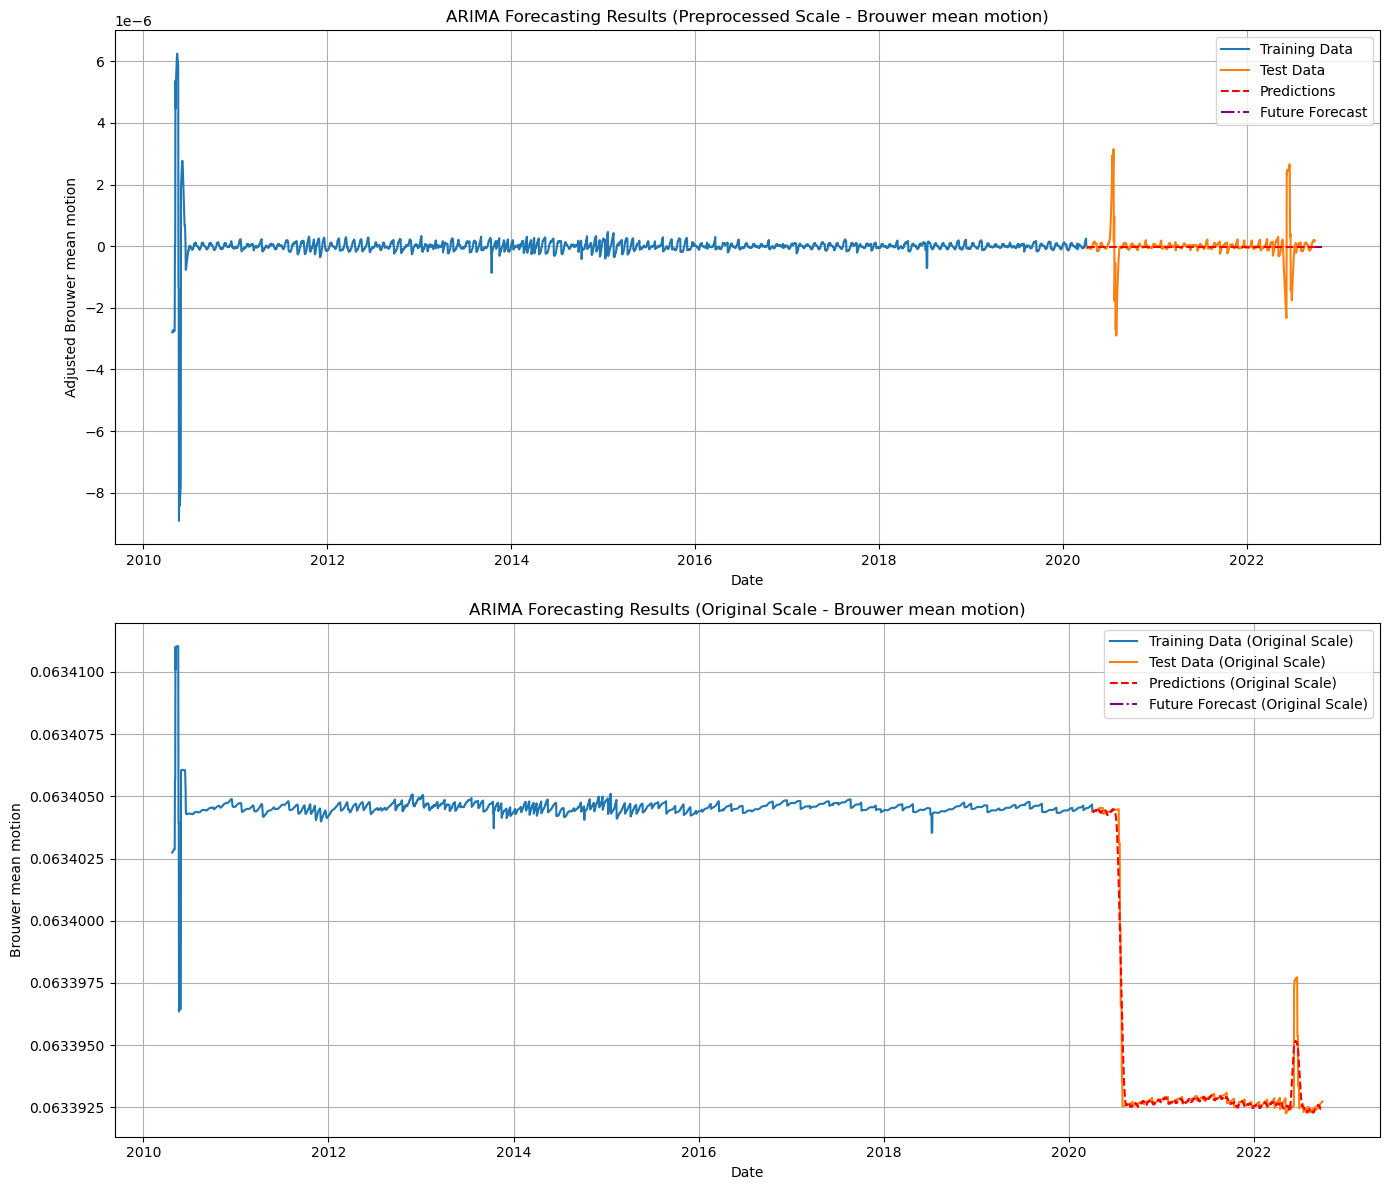

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plotting the preprocessed scale which is detrended and deseasoned
axes[0].plot(train_data.index, train_data, label='Training Data')
axes[0].plot(test_data.index, test_data, label='Test Data')
axes[0].plot(test_data.index, predictions, label='Predictions', color='red', linestyle='--')
axes[0].plot(future_index, future_forecast, label='Future Forecast', color='purple', linestyle='-.')
axes[0].set_title("ARIMA Forecasting Results (Preprocessed Scale - Brouwer mean motion)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Adjusted Brouwer mean motion")
axes[0].legend()
axes[0].grid(True)

# Plotting the original scale recomposed with trend and seasonality
axes[1].plot(Brouwer_mean_motion_daily.index[:train_size], Brouwer_mean_motion_daily.iloc[:train_size], 
             label='Training Data (Original Scale)')
axes[1].plot(test_data.index, Brouwer_mean_motion_daily.reindex(test_data.index), 
             label='Test Data (Original Scale)')
axes[1].plot(test_data.index, recomposed_predictions, 
             label='Predictions (Original Scale)', color='red', linestyle='--')
axes[1].plot(future_index, recomposed_future, 
             label='Future Forecast (Original Scale)', color='purple', linestyle='-.')
axes[1].set_title("ARIMA Forecasting Results (Original Scale - Brouwer mean motion)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Brouwer mean motion")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [33]:
# residuals - difference between forecasts and actual values

In [34]:
# Calculating residuals 
test_predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
residuals = test_data - test_predictions

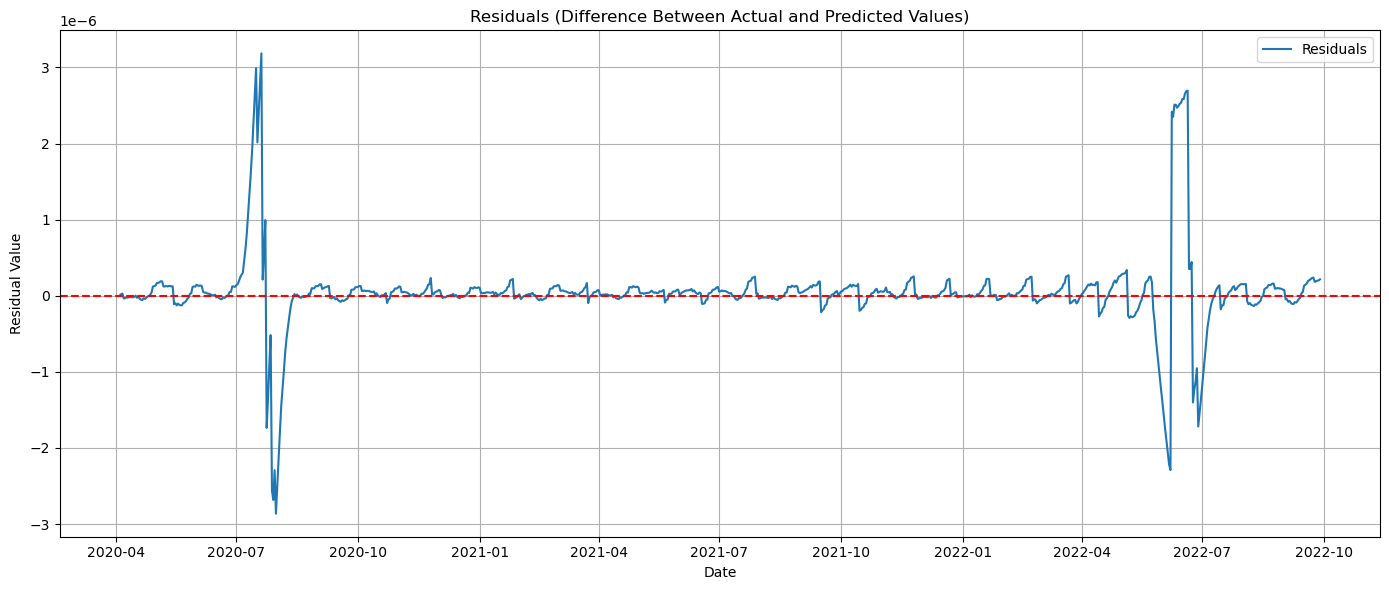

In [35]:
# 1. Plotting the residuals
plt.figure(figsize=(14, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals (Difference Between Actual and Predicted Values)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Implementing manoeuvre detection

In [37]:
# Absolute residuals
abs_residuals = np.abs(residuals)

# Threshold using standard deviation
threshold = abs_residuals.mean() + 2 * abs_residuals.std()

# Detecting manoeuvres where residuals exceed threshold
detected_manoeuvres = residuals[abs_residuals > threshold]

print(f"Threshold value: {threshold:.8f}")
print(f"Number of detected manoeuvres: {len(detected_manoeuvres)}")

Threshold value: 0.00000118
Number of detected manoeuvres: 47


#### Grouping consecutive manoeuvre detected points within 1-2 days to a single manoeuvre event as most of the satellite manoeuvre takes not just one time stamp but takes place for some duration.

In [38]:
detected_dates = detected_manoeuvres.index.tolist()
manoeuvre_events = []

if detected_dates:
    current_event = [detected_dates[0]]
    
    for i in range(1, len(detected_dates)):
        # if within 2 days
        if (detected_dates[i] - current_event[-1]).days <= 2:  
            current_event.append(detected_dates[i])
        else:
            # else its the end of current event and start a new one
            manoeuvre_events.append({
                'start_time': current_event[0],
                'end_time': current_event[-1],
                'max_residual': abs_residuals[current_event].max()
            })
            current_event = [detected_dates[i]]
    
    # Adding the last event
    manoeuvre_events.append({
        'start_time': current_event[0],
        'end_time': current_event[-1],
        'max_residual': abs_residuals[current_event].max()
    })

detected_df = pd.DataFrame(manoeuvre_events)

#### Plotting detected manoeuvres against ground truth

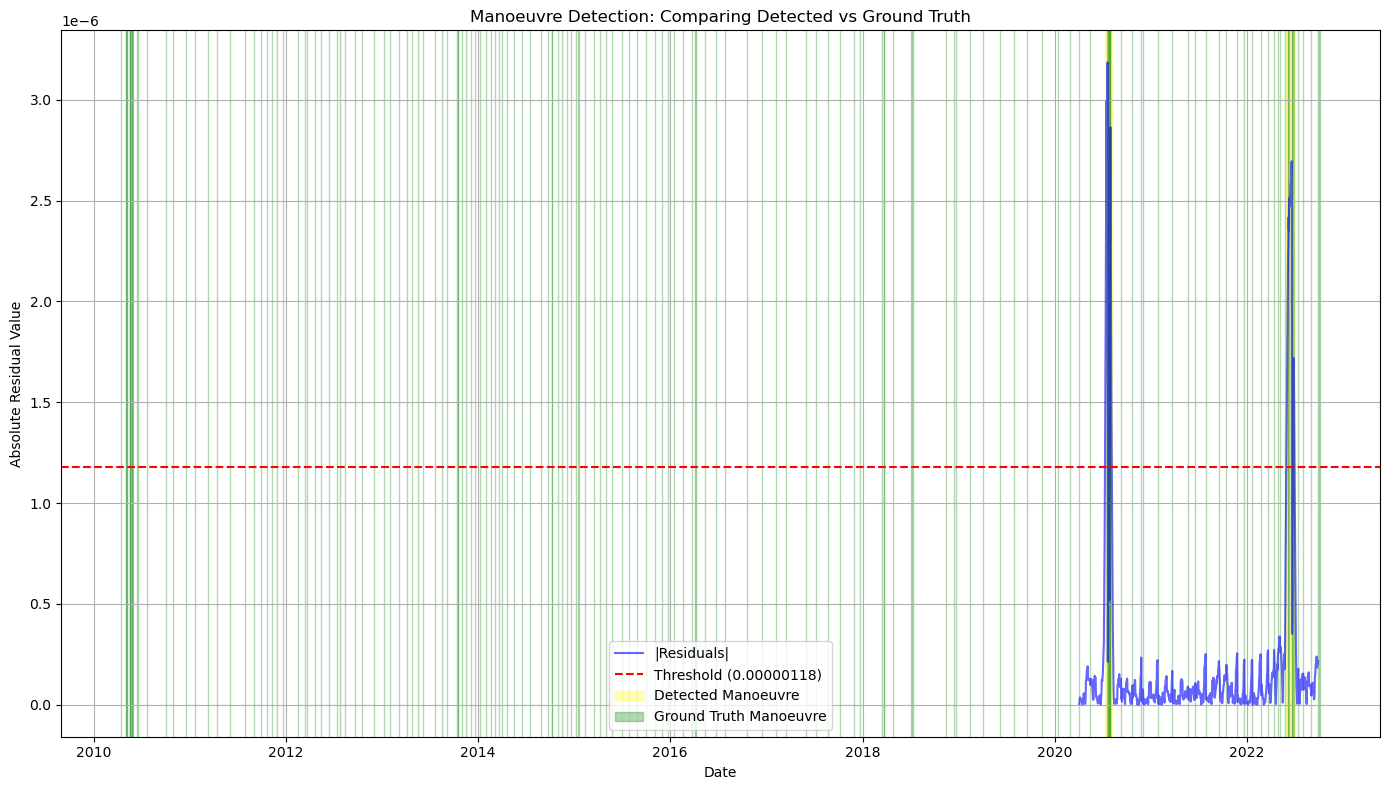

In [39]:
plt.figure(figsize=(14, 8))

# Plotting absolute residuals
plt.plot(abs_residuals.index, abs_residuals, label='|Residuals|', color='blue', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.8f})')

# Plotting detected manoeuvres
for idx, event in enumerate(manoeuvre_events):
    plt.axvspan(event['start_time'], event['end_time'], 
                alpha=0.3, color='yellow', label='Detected Manoeuvre' if idx == 0 else '')

# Plotting ground truth manoeuvres
for idx, row in man_df.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], 
                alpha=0.3, color='green', label='Ground Truth Manoeuvre' if idx == 0 else '')

plt.title('Manoeuvre Detection: Comparing Detected vs Ground Truth')
plt.xlabel('Date')
plt.ylabel('Absolute Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Calculating accuracy metrics

In [40]:
# Quantitative metrics
def calculate_accuracy(detected_df, ground_truth_df, tolerance_days=3):
    true_positives = 0
    false_positives = 0
    
    # For each detected event, check if it's close to a ground truth manoeuvre to get the true and fasle positives
    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        
        if matched:
            true_positives += 1
        else:
            false_positives += 1
    
    # Counting false negatives where ground truth events not detected
    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or            
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break  
        if not matched:
            false_negatives += 1
    
    # Calculating metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

In [41]:
# Printing all the detection accuracy metrics
accuracy_metrics = calculate_accuracy(detected_df, man_df)
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")


Manoeuvre Detection Performance:
True Positives: 6
False Positives: 0
False Negatives: 153
Precision: 1.0000
Recall: 0.0377
F1 Score: 0.0727


In [54]:
# Quantitative metrics
def calculate_accuracy(detected_df, ground_truth_df, total_possible_events, tolerance_days=3):
    true_positives = 0
    false_positives = 0


    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        
        if matched:
            true_positives += 1
        else:
            false_positives += 1


    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or            
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break  
        if not matched:
            false_negatives += 1


    true_negatives = total_possible_events - (true_positives + false_positives + false_negatives)

    # Calculating metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / total_possible_events if total_possible_events > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy
    }


total_possible_events = 109  
accuracy_metrics = calculate_accuracy(detected_df, man_df, total_possible_events)

# Printing all the detection accuracy metrics
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"True Negatives: {accuracy_metrics['true_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")
print(f"Accuracy: {accuracy_metrics['accuracy']:.4f}")



Manoeuvre Detection Performance:
True Positives: 6
False Positives: 0
False Negatives: 153
True Negatives: -50
Precision: 1.0000
Recall: 0.0377
F1 Score: 0.0727
Accuracy: -0.4037


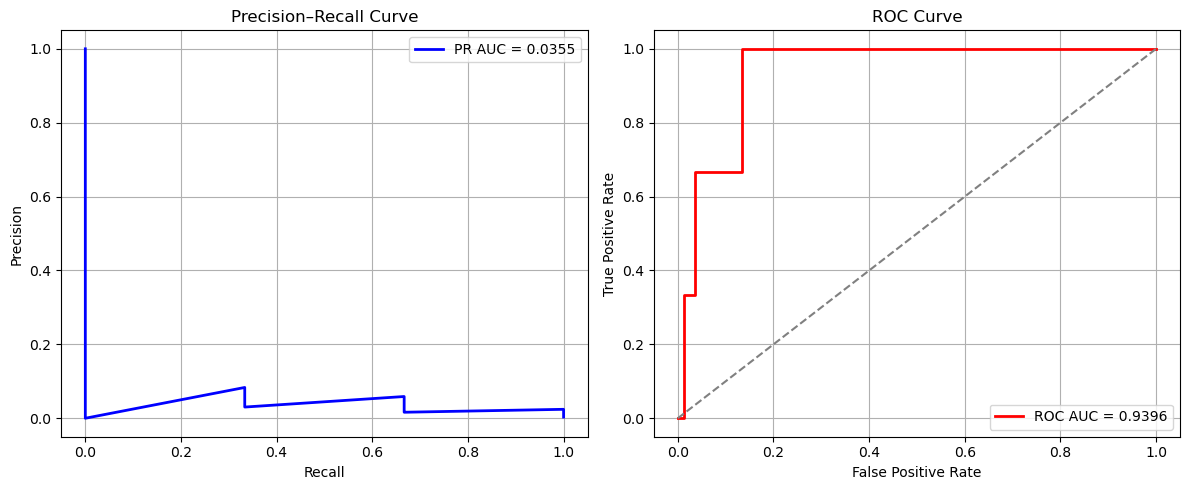

In [43]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

ground_truth_labels = []
for date in abs_residuals.index:
    in_manoeuvre = any(
        (date >= row['start_time']) and (date <= row['end_time'])
        for _, row in man_df.iterrows()
    )
    ground_truth_labels.append(1 if in_manoeuvre else 0)

scores = abs_residuals.values

# Compute Precision Recall curve
precision, recall, pr_thresholds = precision_recall_curve(ground_truth_labels, scores)
pr_auc = auc(recall, precision)

# Compute ROC 
fpr, tpr, roc_thresholds = roc_curve(ground_truth_labels, scores)
roc_auc_value = auc(fpr, tpr)

# Plot Precision Recall curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC AUC = {roc_auc_value:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
# Printing summary table comparing detected vs ground truth manoeuvres
print("\nDetected Manoeuvres:")
print(detected_df[['start_time', 'end_time', 'max_residual']])

print("\nGround Truth Manoeuvres:")
print(man_df[['start_time', 'end_time']])


Detected Manoeuvres:
  start_time   end_time  max_residual
0 2020-07-11 2020-07-20      0.000003
1 2020-07-24 2020-07-25      0.000002
2 2020-07-28 2020-08-05      0.000003
3 2022-05-31 2022-06-20      0.000003
4 2022-06-24 2022-06-25      0.000001
5 2022-06-28 2022-06-30      0.000002

Ground Truth Manoeuvres:
             start_time            end_time
0   2010-04-15 17:47:00 2010-04-15 17:48:00
1   2010-05-03 17:55:00 2010-05-04 00:35:00
2   2010-05-04 18:38:00 2010-05-04 18:48:00
3   2010-05-05 17:44:00 2010-05-05 17:59:00
4   2010-05-06 18:26:00 2010-05-06 18:51:00
..                  ...                 ...
163 2022-08-03 17:18:00 2022-08-03 17:20:00
164 2022-09-01 17:13:00 2022-09-01 17:14:00
165 2022-09-29 16:20:00 2022-09-29 16:22:00
166 2022-10-02 19:36:00 2022-10-02 19:38:00
167 2022-10-05 19:26:00 2022-10-05 19:29:00

[168 rows x 2 columns]


In [45]:
# Plotting detected manoeuvre vs. ground truth

In [46]:
# Fitering the ground truth manoeuvres which comes in between the residual time frame during plotting
man_df_filtered = man_df[
    (man_df['start_time'] >= residuals.index.min()) &
    (man_df['end_time'] <= residuals.index.max())
]

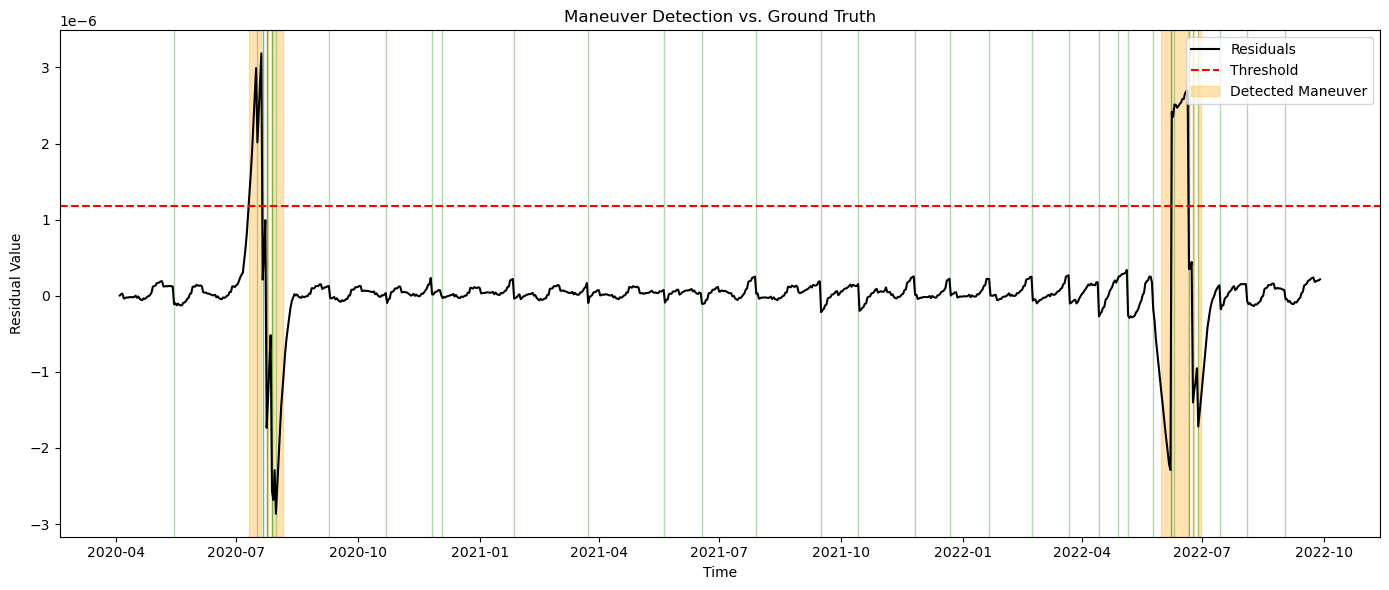

In [47]:
plt.figure(figsize=(14, 6))

# residuals
plt.plot(residuals.index, residuals.values, label='Residuals', color='black')

# threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# detected maneuvers
if not detected_df.empty:
    for idx, row in detected_df.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='orange', alpha=0.3,
                    label='Detected Maneuver' if idx == 0 else "")

# ground truth maneuvers
if not man_df_filtered.empty:
    for idx, row in man_df_filtered.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3,
                    label='Ground Truth Maneuver' if idx == 0 else "")

plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.title('Maneuver Detection vs. Ground Truth')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


#### Detetcting anomaly

In [48]:
# detecting anomaly by checking if the value exceeds the threshold.

In [49]:
def detect_anomalies(residuals, threshold):
    anomalies = []
    in_anomaly = False
    start_time = None
    for time, value in residuals.items():
        if abs(value) > threshold:
            if not in_anomaly:
                in_anomaly = True
                start_time = time
        else:
            if in_anomaly:
                in_anomaly = False
                end_time = time
                anomalies.append({'start_time': start_time, 'end_time': end_time})
    
    # to record the anomaly if the series ended as anomaly
    if in_anomaly:
        anomalies.append({'start_time': start_time, 'end_time': residuals.index[-1]})
    
    return pd.DataFrame(anomalies)

anomalies_df = detect_anomalies(residuals, threshold)
print(anomalies_df)

  start_time   end_time
0 2020-07-11 2020-07-21
1 2020-07-24 2020-07-26
2 2020-07-28 2020-08-06
3 2022-05-31 2022-06-21
4 2022-06-24 2022-06-26
5 2022-06-28 2022-07-01


In [50]:
# Plotting the particular points of anomaly

In [51]:
# Detecting the particular point of anomaly to plot
def detect_anomalies(residuals, threshold):
    anomaly_mask = residuals.abs() > threshold
    return residuals[anomaly_mask]

def plot_all_in_one(observed, predicted, residuals, threshold, man_df):
    anomalies = detect_anomalies(residuals, threshold)

    fig, ax = plt.subplots(figsize=(16, 6))

# Plotting Observed & Predicted
    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)

# Plotting residuals 
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.4, label='Residuals')

# Plotting anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

# Plotting threshold
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plotting ground truth maneuvers
    for idx, row in man_df.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == 0 else "")

    ax.set_title("Anomaly Detection with Ground Truth")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

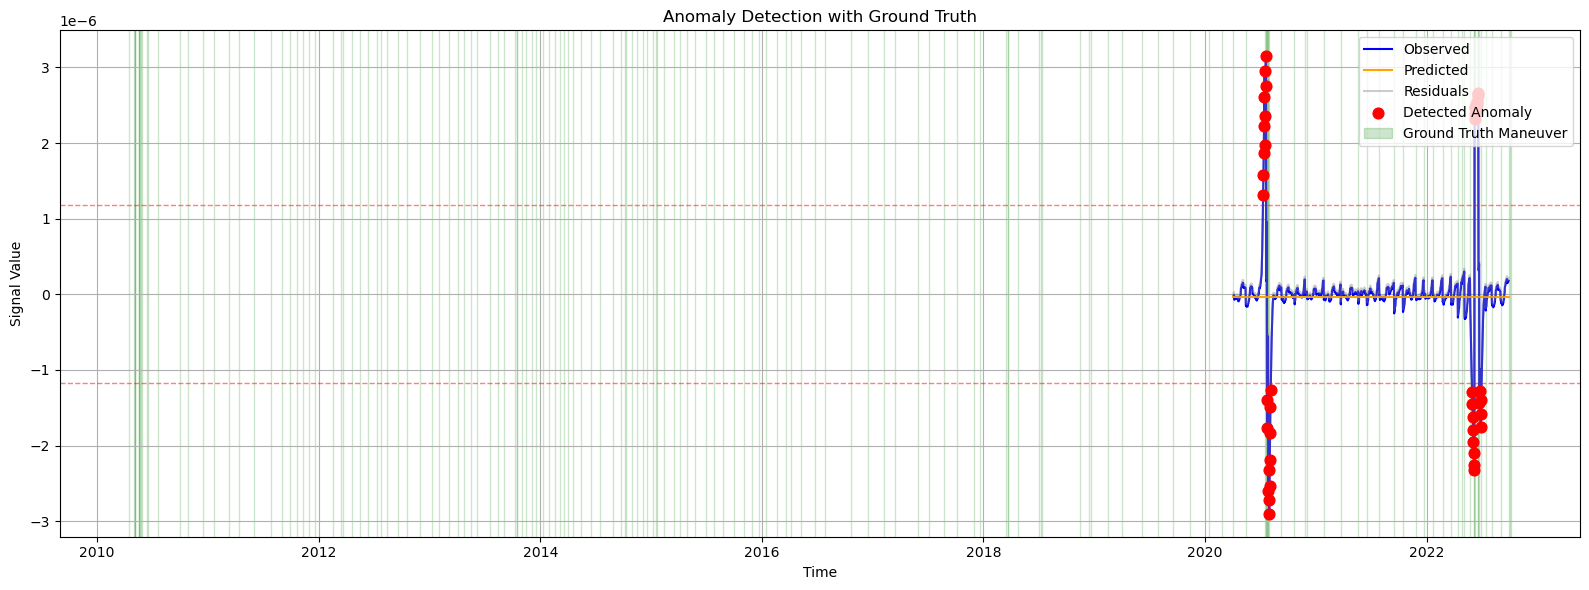

In [ ]:
plot_all_in_one(test_data, test_predictions, residuals, threshold, man_df)

In [52]:
# Focused plot for particular dates 

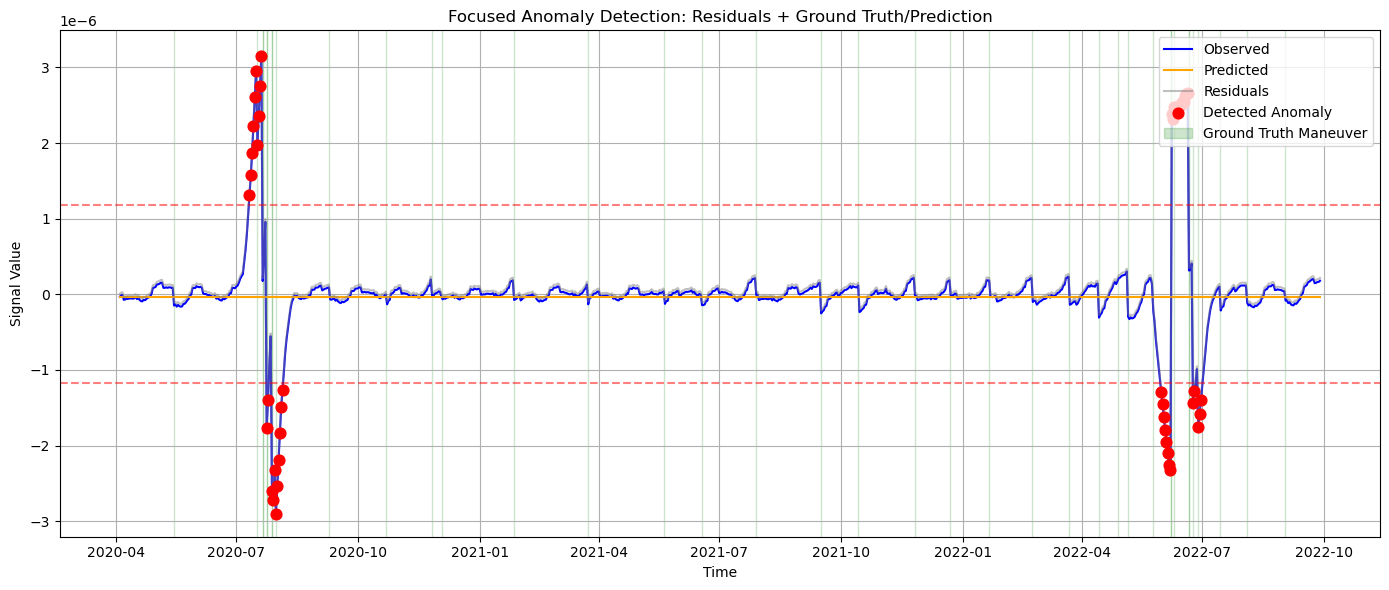

In [53]:
def plot_focused_anomalies(observed, predicted, residuals, threshold, man_df):
    
# Only keeping data where residuals exist to get foccused plot
    valid_times = residuals.dropna().index

# Find overlapping ground truth maneuvers for that points
    valid_man = man_df[
        (man_df['end_time'] >= valid_times.min()) &
        (man_df['start_time'] <= valid_times.max())
    ]

# Start and end time for plotting
    plot_start = max(valid_times.min(), predicted.dropna().index.min())
    plot_end = max(valid_times.max(), predicted.dropna().index.max())

# Filtering all data within the valid time range
    observed = observed[(observed.index >= plot_start) & (observed.index <= plot_end)]
    predicted = predicted[(predicted.index >= plot_start) & (predicted.index <= plot_end)]
    residuals = residuals[(residuals.index >= plot_start) & (residuals.index <= plot_end)]
    anomalies = detect_anomalies(residuals, threshold)
    anomalies = anomalies[(anomalies.index >= plot_start) & (anomalies.index <= plot_end)]

# Filtering maneuvers that intersect this range
    valid_man = valid_man[
        (valid_man['start_time'] <= plot_end) &
        (valid_man['end_time'] >= plot_start)
    ]

# Plot
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.5, label='Residuals')

# Detected anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

# Residual threshold 
    ax.axhline(threshold, linestyle='--', color='red', alpha=0.5)
    ax.axhline(-threshold, linestyle='--', color='red', alpha=0.5)

# Ground truth
    for idx, row in valid_man.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == valid_man.index[0] else "")

    ax.set_title("Focused Anomaly Detection: Residuals + Ground Truth/Prediction")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_focused_anomalies(test_data, test_predictions, residuals, threshold, man_df)